In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel, pipeline
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import ast
import re
from datetime import datetime

### 1. Import data

In [126]:
# Load an array with generated indices and similarity scores:
data = np.load(r'.\..\data\cos_similarity\recommendations_300_merged_sentiment.npz')
indices = data["indices"]
similarity_scores = data["similarity_scores"]

In [127]:
# Load the DataFrame with user vectors:
file_path_user_vec = rf'.\..\data\text_analysis\user_vectors\user_vectors_merged.csv'
df_user_vectors = pd.read_csv(file_path_user_vec)
df_user_vectors

,user_ID,user_vec_0,user_vec_1,user_vec_2,user_vec_3,user_vec_4,user_vec_5,user_vec_6,user_vec_7,user_vec_8,...,user_vec_290,user_vec_291,user_vec_292,user_vec_293,user_vec_294,user_vec_295,user_vec_296,user_vec_297,user_vec_298,user_vec_299
0,AE222BBOVZIF42YOOPNBXL4UUMYA,0.022338,0.100595,-0.206153,0.065659,0.023273,0.011930,0.054218,0.009806,0.071820,...,-0.001122,0.004642,-0.001718,-0.007591,-0.007428,0.001374,-0.018390,-0.007487,0.000145,0.006247
1,AE222FP7YRNFCEQ2W3ZDIGMSYTLQ,0.022153,0.030388,-0.094107,-0.025539,0.093637,0.170470,-0.031770,-0.060638,-0.060701,...,0.001796,-0.002748,0.003149,0.006347,0.020818,-0.002077,0.013311,-0.006835,-0.007763,-0.002501
2,AE222X475JC6ONXMIKZDFGQ7IAUA,-0.012598,0.219775,0.142422,-0.017760,0.129527,0.076851,0.021589,-0.034965,-0.045799,...,-0.022207,-0.002645,0.041338,-0.015161,0.011363,-0.026213,0.002272,0.003468,-0.002008,0.002792
3,AE222Y4WTST6BUZ4J5Y2H6QMBITQ,-0.231625,-0.016032,-0.102149,0.066109,-0.050187,0.007027,0.020258,0.010995,-0.007235,...,-0.006156,-0.003489,-0.000958,0.016319,-0.011625,-0.000594,0.007983,-0.010001,0.012913,-0.001186
4,AE2232TEZOEWQLAFEX2NA6VBGMYQ,0.237254,-0.088060,0.097924,0.076692,0.160438,0.100078,-0.051536,-0.046282,0.132318,...,0.003213,-0.006024,-0.003414,0.001399,0.021043,0.006149,0.000152,-0.002788,0.010600,0.002627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630310,AHZZYVEU6QFMPFZ2HJUWR22SNK4A,-0.012253,0.347016,-0.028917,-0.132051,0.016790,0.109174,-0.088193,0.002015,0.039121,...,-0.004510,0.007740,0.009071,-0.001471,-0.009232,0.002643,-0.008750,0.005727,0.000474,0.001073
630311,AHZZZAK24AJ3JNBDUZJGHHWSRVAA,-0.199268,-0.009690,0.018537,0.045325,0.030314,-0.013304,0.056271,0.021373,0.043239,...,-0.009092,0.003253,-0.014467,0.000982,-0.000779,0.004438,0.001680,0.002672,0.002944,0.006786
630312,AHZZZJP24QUSB5XWW6MAXYBZZZSQ,0.027290,0.176118,-0.098011,0.141308,0.048202,-0.112999,0.012363,-0.028594,0.050939,...,-0.002248,0.009882,0.004362,0.001602,0.005781,-0.003056,0.002786,0.011582,-0.017130,0.006931
630313,AHZZZL7YQJA3RSA6PYK3WMFACYIQ,0.114299,-0.025805,-0.125545,-0.037366,-0.196658,-0.016408,0.053420,0.040763,-0.058073,...,0.004117,-0.000237,0.003289,-0.003952,-0.009725,-0.004431,-0.008974,0.007798,0.000113,-0.001615


In [128]:
# Load the DataFrame with product vectors:
file_path_product_vec = rf'.\..\data\text_analysis\product_vectors\product_vectors_merged_sentiment.csv'
df_product_vectors = pd.read_csv(file_path_product_vec)
df_product_vectors

,product_ID,product_vec_0,product_vec_1,product_vec_2,product_vec_3,product_vec_4,product_vec_5,product_vec_6,product_vec_7,product_vec_8,...,product_vec_290,product_vec_291,product_vec_292,product_vec_293,product_vec_294,product_vec_295,product_vec_296,product_vec_297,product_vec_298,product_vec_299
0,0005946468,0.005288,0.247759,0.103427,-0.091621,0.005084,-0.099639,-0.107011,0.122461,0.012713,...,0.002068,0.009174,-0.019991,-0.003565,-0.003649,-0.017079,-0.013606,0.001881,0.015874,-0.002307
1,0123034892,0.109861,0.275601,0.000386,-0.047517,0.004198,-0.083188,-0.079647,-0.121367,0.129342,...,-0.007957,-0.009873,0.003017,0.015212,-0.005792,0.007390,0.004461,0.001337,0.009957,-0.012407
2,0124784577,-0.017208,0.132227,0.100658,-0.126151,0.059223,0.032017,-0.042822,0.087571,0.032354,...,-0.005163,-0.009594,-0.002201,0.013803,0.002335,0.004500,-0.009917,0.001281,-0.000278,-0.003500
3,0515059560,-0.209201,-0.058736,0.202120,0.062009,-0.090060,0.028901,-0.018587,0.080671,-0.056896,...,-0.010150,0.030672,-0.013799,0.020456,-0.005572,-0.030364,0.009011,-0.004363,-0.024073,0.008783
4,0692508988,-0.229014,-0.004910,0.084747,0.074721,-0.113337,0.017797,-0.113408,0.059619,-0.109043,...,0.002954,0.007351,-0.000078,0.020734,-0.009473,-0.010563,0.007831,0.008652,-0.000035,0.000989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96521,B0CBMFK1S2,-0.067334,0.154381,-0.197790,-0.023412,0.010574,-0.022570,0.074094,-0.099601,0.037623,...,0.010685,-0.005477,0.001734,0.002790,-0.004053,0.008070,-0.002784,-0.001871,0.003500,0.010731
96522,B0CBWDTY41,0.069057,0.038905,-0.166532,-0.235593,-0.038300,0.060362,-0.100929,0.040324,-0.045593,...,-0.010125,0.001486,0.003190,0.004283,0.005094,-0.000096,-0.000655,-0.001726,0.001275,-0.004093
96523,B0CBXM7WHY,-0.169268,0.007456,0.089662,-0.067994,0.013050,0.057634,-0.050431,-0.041138,0.025872,...,-0.009981,0.013271,-0.008269,-0.003295,0.014088,-0.008365,0.004828,0.003399,0.010965,-0.004015
96524,B0CCPDTRK7,0.118037,-0.196848,-0.070833,-0.118934,0.010600,0.104431,-0.061131,-0.024269,-0.122102,...,0.002205,0.009895,0.001180,-0.001901,0.007467,-0.010565,0.000210,0.000453,0.006803,-0.002013


In [129]:
# load the dataset of PCA normalized embeddings: 
file_path = rf'.\..\data\embeddings_dim_reduction\df_user_normalized_PCA_merged.csv' # adjust the filepath with the proper file 
df_user_normalized_PCA = pd.read_csv(file_path) 

In [130]:
# Upload the user DataFrame and analyse the recommendations
file_path = r'.\..\data\data_clean\merged_user_meta_df.csv'  # Update this with your file path
df_user = pd.read_csv(file_path)

In [132]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693941 entries, 0 to 693940
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   rating                      693941 non-null  int64 
 1   review_title                693941 non-null  object
 2   text_review                 693941 non-null  object
 3   user_images                 693941 non-null  object
 4   product_ID                  693941 non-null  object
 5   parent_ID                   693941 non-null  object
 6   user_ID                     693941 non-null  object
 7   timestamp                   693941 non-null  object
 8   helpful_review_vote         693941 non-null  int64 
 9   user_purchase_verification  693941 non-null  int64 
 10  year                        693941 non-null  int64 
 11  cleaned_text                692536 non-null  object
 12  parent_asin                 693941 non-null  object
 13  cleaned_title               6

### 2. Run recommendations for the specific user_id

### Compare Reviews - Similarity Research with COS Similarity

* Extract the user and product vectors.
* Compute the cosine similarity between each user and all products (already precalculated matrix for 300 closest vectors)
* Rank products for each user based on similarity scores.

Create a DataFrame that stores all items that user purchased, to remove those from the recommendations

In [133]:
user_item_df = df_user_normalized_PCA.groupby('user_ID')['product_ID'].apply(list).reset_index()
user_item_df

,user_ID,product_ID
0,AE222BBOVZIF42YOOPNBXL4UUMYA,[B013HR1A92]
1,AE222FP7YRNFCEQ2W3ZDIGMSYTLQ,[B0BTT658PQ]
2,AE222X475JC6ONXMIKZDFGQ7IAUA,[B00PBDMRES]
3,AE222Y4WTST6BUZ4J5Y2H6QMBITQ,[B00012FPSO]
4,AE2232TEZOEWQLAFEX2NA6VBGMYQ,[B07QNPXBLH]
...,...,...
630310,AHZZYVEU6QFMPFZ2HJUWR22SNK4A,[B07JJ9NFFH]
630311,AHZZZAK24AJ3JNBDUZJGHHWSRVAA,[B00KXFD75M]
630312,AHZZZJP24QUSB5XWW6MAXYBZZZSQ,[B00IG0677G]
630313,AHZZZL7YQJA3RSA6PYK3WMFACYIQ,[B091TKH1JF]


In [134]:
df_user_normalized_PCA['user_ID'].value_counts()

user_ID
AG73BVBKUOH22USSFJA5ZWL7AKXA      165
AEZP6Z2C5AVQDZAJECQYZWQRNG3Q      146
AEMP3A7IKW37CMWFXNKXWW6HGJHA_1    115
AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1     87
AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2     83
                                 ... 
AEX24LYNE5WPGISAP425SQPUKJXQ        1
AFSMCZTEUW3TI2BSPE25BD5GKXLA        1
AGKNUO4XOIPCSIKDRHO56UQDPXVQ        1
AEJQRDONU2O5LSOD5OC77XO43DFA        1
AGIYQU6RK6TBKBCMWKVPBPBMMJNA        1
Name: count, Length: 630315, dtype: int64

In [135]:
unique_combinations = df_user_normalized_PCA[['user_ID', 'product_ID']].value_counts()
unique_combinations

user_ID                       product_ID
AGWOOXMW2IXPKZOWAIWNMCXY7LBQ  B09NS1VG4L    2
AGPGHXWBOK3TRJU7WACF5AAYBBVQ  B0B18CG44R    1
AGPGHNJ32YJHVI2YKOBYQHSJS4WQ  B07L5QVV6W    1
AGPGHPOQZP7XKLM6KJF2E6JT3D5A  B07DLF8HKR    1
AGPGHQIMPLOJD3FR3ODRDJFYSJBQ  B079D87KKM    1
                                           ..
AFENC7VBDKGZQXZO437KEQWP45WA  B07Z2QTWSW    1
AFENCIKTUQKQM2YPBVDGBB4S6OZQ  B01KU867GM    1
AFENCVCHNNX3UATG4KRVIPYJLLGQ  B00YZ0XOWC    1
AFENDQSAV5XVGGXKHRSDE3DUYK4A  B00D4T40D2    1
AHZZZSOTVOVACVK2WWXL4ITEAPIA  B00R1TAN7I    1
Name: count, Length: 692330, dtype: int64

In [136]:
# Extract user vectors
user_ids = df_user_vectors['user_ID'].values
user_vectors = df_user_vectors.iloc[:, 1:].values

# Extract product vectors
product_ids = df_product_vectors['product_ID'].values
product_vectors = df_product_vectors.iloc[:, 1:].values

In [137]:
def recommend_top_n_products_by_user_id(user_id, user_ids, similarity_scores, indices, product_ids, user_item_df, top_n=10):
    """
    Recommend top N products for a given user based on precomputed top-N cosine similarity.

    Parameters:
    - user_id: User ID for whom to generate recommendations
    - user_ids: List of user IDs corresponding to rows in similarity data
    - similarity_scores: Precomputed top-N similarity scores (users x top-N products)
    - indices: Indices of the top-N products for each user
    - product_ids: List of product IDs corresponding to the product vectors
    - user_item_df: DataFrame containing user-product interactions
    - top_n: Number of top recommendations to return

    Returns:
    - List of (product_id, similarity_score) tuples
    """

    # Find the index of the user_ID
    if user_id not in user_ids:
        raise ValueError(f"User ID '{user_id}' not found in the user data.")
    
    user_index = np.where(user_ids == user_id)[0][0]  # Locate the index of user_id

    # Get top-N similarity scores and product indices for this user
    user_similarities = similarity_scores[user_index]
    user_product_indices = indices[user_index]

    # Retrieve the list of already purchased products for the user
    purchased_products = user_item_df.loc[user_item_df['user_ID'] == user_id, 'product_ID']
    if not purchased_products.empty:
        # Flatten and handle lists or non-hashable elements in purchased_products
        if purchased_products.apply(lambda x: isinstance(x, list)).any():
            purchased_products = set([item for sublist in purchased_products for item in sublist])
        else:
            purchased_products = set(purchased_products)
    else:
        purchased_products = set()

    # Filter and sort recommendations
    recommendations = []
    for i, product_index in enumerate(user_product_indices):
        product = product_ids[product_index]
        if product not in purchased_products:
            recommendations.append((product, user_similarities[i]))
        if len(recommendations) >= top_n:  # Stop when we have enough recommendations
            break
    
    return recommendations

# Example usage
user_id_input = "AGKHLEW2SOWHNMFQIJGBECAF7INQ"  # Replace with user_ID
top_n = 10

try:
    recommendations = recommend_top_n_products_by_user_id(
        user_id_input, 
        user_ids, 
        similarity_scores, 
        indices, 
        product_ids, 
        user_item_df, 
        top_n
    )

    print(f"Top-{top_n} Recommendations for User '{user_id_input}':")
    for product_id, score in recommendations:
        print(f"Product ID: {product_id}, Similarity Score: {score:.4f}")
except ValueError as e:
    print(e)


Top-10 Recommendations for User 'AGKHLEW2SOWHNMFQIJGBECAF7INQ':
Product ID: B081QVZ8CV, Similarity Score: 0.7219
Product ID: B081TH5HJJ, Similarity Score: 0.6884
Product ID: B08KNVV18L, Similarity Score: 0.6792
Product ID: B0BQWTXV2Q, Similarity Score: 0.6746
Product ID: B07PXFPVZK, Similarity Score: 0.6722
Product ID: B017Y3S58Y, Similarity Score: 0.6695
Product ID: B00Z5OJPS4, Similarity Score: 0.6692
Product ID: B07D5FBFQ4, Similarity Score: 0.6672
Product ID: B081QVJWRY, Similarity Score: 0.6535
Product ID: B076CGJ599, Similarity Score: 0.6494


In [138]:
recommendations

[('B081QVZ8CV', 0.7219040308117793),
 ('B081TH5HJJ', 0.6883898574114142),
 ('B08KNVV18L', 0.6792447475150609),
 ('B0BQWTXV2Q', 0.6746444653078986),
 ('B07PXFPVZK', 0.6721985882025647),
 ('B017Y3S58Y', 0.6694916803558769),
 ('B00Z5OJPS4', 0.6691648673741817),
 ('B07D5FBFQ4', 0.6671881207739409),
 ('B081QVJWRY', 0.653463215666938),
 ('B076CGJ599', 0.6494314094692981)]

In [139]:
# Extract product IDs:
product_ids = [item[0] for item in recommendations]
product_ids

['B081QVZ8CV',
 'B081TH5HJJ',
 'B08KNVV18L',
 'B0BQWTXV2Q',
 'B07PXFPVZK',
 'B017Y3S58Y',
 'B00Z5OJPS4',
 'B07D5FBFQ4',
 'B081QVJWRY',
 'B076CGJ599']

In [140]:
# Find users who ourchased more than 1 product to verify the recommendations for them:
duplicated_user_ids = df_user_normalized_PCA['user_ID'][df_user_normalized_PCA['user_ID'].duplicated()].unique()
duplicated_user_ids

array(['AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'AFQLNQNQYFWQZPJQZS6V3NZU4QBQ',
       'AFSKPY37N3C43SOI5IEXEK5JSIYA', ...,
       'AFV3EYFZLLLBWIXWRZUSRJOHLNBA', 'AEVTGJFLW22HVSWOJLJCBJUN46WA',
       'AHURE3VT2MLCTARMYI7JA7KKDYAA'], dtype=object)

In [141]:
pd.set_option('display.max_colwidth', None)

Analyse users purchase:

In [142]:
single_user_check = df_user[df_user['user_ID']=='AGKHLEW2SOWHNMFQIJGBECAF7INQ']
single_user_check

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification,year,cleaned_text,parent_asin,cleaned_title
0,5,Such a lovely scent but not overpowering.,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,1,2020,"this spray is really nice. it smells really good, goes on really fine, and does the trick. i will say it feels like you need a lot of it though to get the texture i want. i have a lot of hair, medium thickness. i am comparing to other brands with yucky chemicals so im gonna stick with this. try it!",B00YQ6X8EO,herbivore natural sea mist texturizing salt spray coconut 8 oz
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,1,2020,"this product does what i need it to do, i just wish it was odorless or had a soft coconut smell. having my head smell like an orange coffee is offputting. granted, i did know the smell was described but i was hoping it would be light",B081TJ8YS3,all natural vegan dry shampoo powder eco friendly root touch up hair powder volumizer for brown hair brunette and dark hair brun application brush two goats apothecary


Analyse recommended products:

In [143]:
# Analyse recommended products
filtered_df = df_user[df_user['product_ID'].isin(product_ids)]
filtered_df.head()

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification,year,cleaned_text,parent_asin,cleaned_title
281,5,really liked that the product didn't have greasy or heavy feel ...,"Starters, I LOOOOOOOOVE tea tree scent, strong, but not overpowering or nasty in synthetic way. As conditioner, really liked that the product didn't have greasy or heavy feel as I applied it to my hair. Nice smoothness after drying, liked the feel,of my hair, but no major fragrance afterwards, which I like. Treats my scalp in good condition too.",[],B00Z5OJPS4,B00Z5OJPS4,AHPFHP43AXWRYZZ4HPNCW7I7J3ZQ,2017-08-12 12:27:36.260,1,0,2017,"starters, i loooooooove tea tree scent, strong, but not overpowering or nasty in synthetic way. as conditioner, really liked that the product didnt have greasy or heavy feel as i applied it to my hair. nice smoothness after drying, liked the feel,of my hair, but no major fragrance afterwards, which i like. treats my scalp in good condition too.",B00Z5OJPS4,organic doctor organic tea tree conditioner 9 floz
781,5,"Softest hands ever, lightly scented w/ lemongrass oil, lemon oil, orange oil, rosemary","I love Leap bar soaps (LOVE!), and was curious about their liquid hand soap. It is a 12 ounce pump style bottle with visually pleasing label. The soap comes out thick and rich. It is super luxurious feeling- it lathers significantly all the while feeling like hand cream. It rinses well and leaves skin feeling soft. Probably the most soft. Perhaps a little coating of glycerin and aloe are left behind? Yet not a gross coating. I am trying to figure out the magic of my soft, smooth, clean feeling hands on a super cold (18*F), dry day. Super moisturizing.<br /><br />Oddly, I find it has barely any scent. I am used to their super scented bar soaps, and I was expecting a stronger scent to come through. I am not usually keen on perfume (causes headaches, nausea), but when a product uses essential oils for scenting (especially hand soap and house cleaners), I find it delightfully uplifting. This is labeled as lemongrass, but that isn't the only essential oil used. The profile is more complex with the addition of lemon oil, orange oil, and rosemary. I was really excited for this to have a robust citrus smell. I really couldn't tell you just by sniffing. It smells fresh and clean, but it isn't strong (and I was hoping/expecting strong). I see other reviewers mentioning a strong smell. I figured I got a weird bottle or I have covid. I actually went and grabbed my Leap bar soap to make sure I could still smell that. I can. Phew.<br /><br />I'm still going 5 stars because it does have a mild fresh scent, and the soap itself is glorious. Very rich, super moisturizing lather. And it rinses away perfectly. I dont feel like I am working to get the soap off. If it did, I wouldn't like that. So there is some sorcery involved here, lol. I kinda want it as a body wash. My hands feel SO GOOD after using this. I just keep touching my hands.<br /><br />One does not need a lot of soap, so feel free to just add a little to the hand. I would even go so far as to add a little water as it goes down. Or if you like this soap and have a foamer, then just a wee bit of this with a lot of water will do it.<br /><br />Love their designs on the bottles.<br /><br />Water, Organic Coconut Oil, Organic Olive Oil, Vegetable Glycerin, Organic Guar Gum, Lemongrass Oil, Orange Oil, Organic Jojoba Oil, Lemon Oil, Rosemary Extract, Organic Aloe Vera (Potassium Hydroxide is used to saponify the organic oils into soap, but none remains in the final product)",[],B08KNVV18L,B08KNVV18L,AF2BLE54TEMGZ546U763ZHZRXC4A,2020-12-18 17:42:00.919,0,0,2020,"i love leap bar soaps love!, and was curious about their liquid hand soap. it is a 12 ounce pump style bottle with visually pleasing label. the soap comes out thick and rich. it is super luxurious feeling it lathers significantly all the while feeling like hand cr

In [144]:

# Display the cleaned_text column
filtered_df.cleaned_text

281                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## Plotting

Vectors reduction for vizualization purposes  - visualize the similarity by connecting points with lines where similarity is high.

In [145]:
user_vectors_sub = user_vectors[:1000]
product_vectors_sub = product_vectors[:800]


# Combine user and product vectors
all_vectors = np.vstack((user_vectors_sub, product_vectors_sub))

# Create labels to distinguish between users and products
labels = np.array(['User'] * len(user_vectors_sub) + ['Product'] * len(product_vectors_sub))

In [146]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for 2D reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
vectors_2d = tsne.fit_transform(all_vectors)

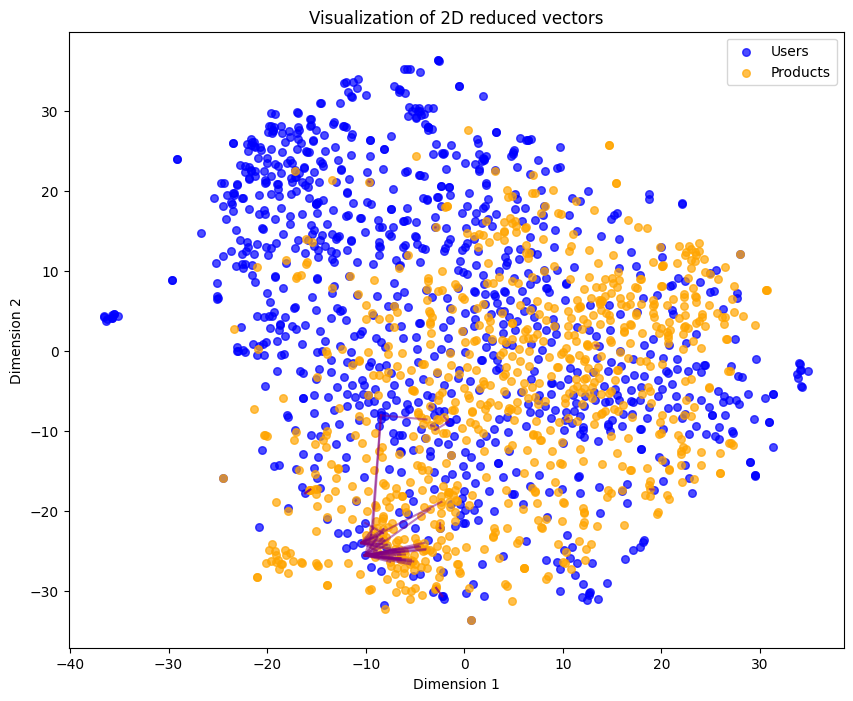

In [147]:
similarity_matrix = cosine_similarity(user_vectors_sub, product_vectors_sub)

# Threshold for drawing lines 
threshold = 0.72

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:len(user_vectors_sub), 0], vectors_2d[:len(user_vectors_sub), 1], 
            label='Users', c='blue', alpha=0.7, s=30)
plt.scatter(vectors_2d[len(user_vectors_sub):, 0], vectors_2d[len(user_vectors_sub):, 1], 
            label='Products', c='orange', alpha=0.7, s=30)

# Draw lines for high similarity
for i, user_point in enumerate(vectors_2d[:len(user_vectors_sub)]):
    for j, product_point in enumerate(vectors_2d[len(user_vectors_sub):]):
        if similarity_matrix[i, j] > threshold:
            plt.plot([user_point[0], product_point[0]], 
                     [user_point[1], product_point[1]], 
                     c='purple', alpha=0.5)

plt.title('Visualization of 2D reduced vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


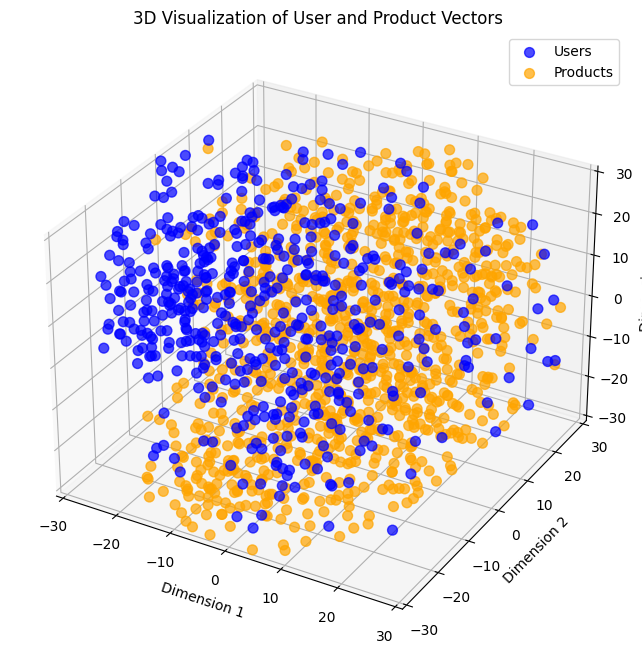

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

user_vectors_sub = user_vectors[:500]
product_vectors_sub = product_vectors[:1000]


# Assuming `user_vectors` and `product_vectors` are your numpy arrays
# Combine user and product vectors
all_vectors = np.vstack((user_vectors_sub, product_vectors_sub))
labels = np.array(['User'] * len(user_vectors) + ['Product'] * len(product_vectors_sub))

# Apply t-SNE for 3D dimensionality reduction
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
vectors_3d = tsne.fit_transform(all_vectors)

# 3D Scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot users
ax.scatter(
    vectors_3d[:len(user_vectors_sub), 0], 
    vectors_3d[:len(user_vectors_sub), 1], 
    vectors_3d[:len(user_vectors_sub), 2], 
    c='blue', label='Users', alpha=0.7, s=50
)

# Plot products
ax.scatter(
    vectors_3d[len(user_vectors_sub):, 0], 
    vectors_3d[len(user_vectors_sub):, 1], 
    vectors_3d[len(user_vectors_sub):, 2], 
    c='orange', label='Products', alpha=0.7, s=50
)

# Customize axis scales
ax.set_xlim([-30, 30])  # Set the range for the X-axis
ax.set_ylim([-30, 30])  # Set the range for the Y-axis
ax.set_zlim([-30, 30])  # Set the range for the Z-axis


# Add labels and title
ax.set_title('3D Visualization of User and Product Vectors')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()

plt.show()


In [149]:
!pip install plotly

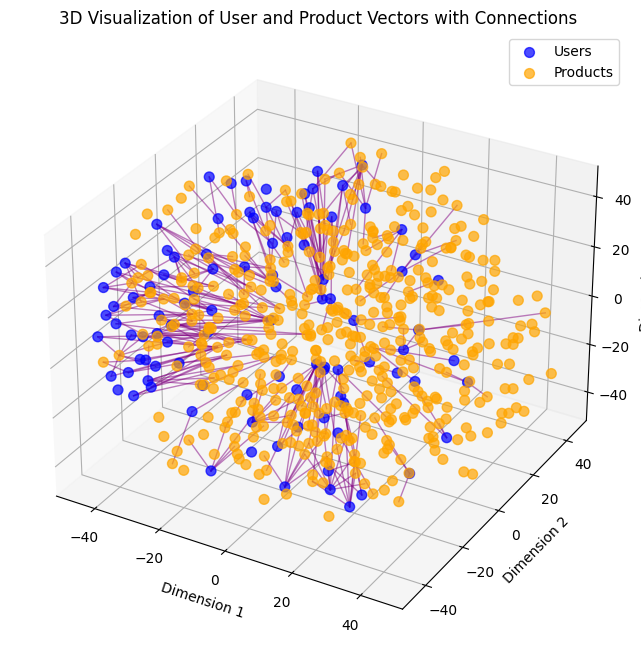

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

user_vectors_sub = user_vectors[:100]
product_vectors_sub = product_vectors[:500]

# Combine user and product vectors
all_vectors = np.vstack((user_vectors_sub, product_vectors_sub))

# Apply t-SNE for 3D dimensionality reduction
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
vectors_3d = tsne.fit_transform(all_vectors)

# Separate user and product vectors after dimensionality reduction
user_vectors_3d = vectors_3d[:len(user_vectors_sub)]
product_vectors_3d = vectors_3d[len(user_vectors_sub):]

# Compute similarity matrix (cosine similarity or use cdist for distance)
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(user_vectors_3d, product_vectors_3d)

# Define a similarity threshold
similarity_threshold = 0.98

# 3D Scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot users
ax.scatter(
    user_vectors_3d[:, 0], 
    user_vectors_3d[:, 1], 
    user_vectors_3d[:, 2], 
    c='blue', label='Users', alpha=0.7, s=50
)

# Plot products
ax.scatter(
    product_vectors_3d[:, 0], 
    product_vectors_3d[:, 1], 
    product_vectors_3d[:, 2], 
    c='orange', label='Products', alpha=0.7, s=50
)

# Draw lines for high similarity
for i, user_point in enumerate(user_vectors_3d):
    for j, product_point in enumerate(product_vectors_3d):
        if similarity_matrix[i, j] > similarity_threshold:  # Only connect similar points
            ax.plot(
                [user_point[0], product_point[0]],
                [user_point[1], product_point[1]],
                [user_point[2], product_point[2]],
                c='purple', alpha=0.5, linewidth=1
            )

# Customize axis scales (optional)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

# Add labels and title
ax.set_title('3D Visualization of User and Product Vectors with Connections')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()

plt.show()
